# Objectif du projet 
Le but de ce projet est de construire un réseau de neurones qui classifie en étant 
capable de définir si une personne a été satisfaite de son vol (oui ou non) en fonction de différents paramètres. 
Pour réaliser ce projet on partira avec un dataset d'entraînement et de test déjà rempli.

## Import des librairies

In [215]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.optimizers import Adam,SGD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

## 1 - Analyse et manipulation des données 
Dans cette partie on va s'attarder à importer nos données et à venir les manipuler pour qu'on puisse les comprendre

In [216]:
test_set = pd.read_csv(os.getcwd()+"/test.csv",usecols=lambda column: column != 'Unnamed: 0') # jeu de données de test 
training_set = pd.read_csv(os.getcwd()+"/train.csv",usecols=lambda column: column != 'Unnamed: 0') # jeu de donnéees de train 
training_set.head() # afficher l'en-tête des données pour comprendre à quoi elle ressemble 

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Nettoyage des données inutiles
On va reprérer les données qui sont à null pour les supprimer du dataset


In [217]:
print(training_set.shape)
training_set.dropna(axis=0, inplace=True)
test_set.dropna(axis=0,inplace=True)
print(training_set.shape)
training_set.drop("id",axis=1,inplace=True)
test_set.drop("id",axis=1,inplace=True)

(103904, 24)
(103594, 24)


### Répérage de la colonne qui nous intéresse
La colonne qui va nous intéresser est la toute dernière du jeu de données. C'est elle qui va nous permettre de classer 
de façon binaire. 

In [218]:
val_unique = training_set['satisfaction'].unique()
val_formates = ' et '.join(['"{}"'.format(valeur) for valeur in val_unique])
print("Les valeurs uniques de la colonne 'satisfaction' sont : ", val_formates)

Les valeurs uniques de la colonne 'satisfaction' sont :  "neutral or dissatisfied" et "satisfied"


### Encodage des données
On remarque que certaines données sont au format non numérique (object). Pour que notre modèle soit en capacité de comprendre ces valeurs on va devoir les transformer au format numérique. Ainsi on admet que chaque caractéristiques (features) du dataset
initial sont importantes.

In [219]:
training_set.dtypes # liste des champs avec leur format 

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

In [220]:
label_encoder = LabelEncoder() # on instancie un encoder qui va associer à une chaîne de caractère un format numérique
colonnes_a_encoder = ['Gender', 'Customer Type', 'Type of Travel','Class','satisfaction']
for col in colonnes_a_encoder:
    training_set[col] = label_encoder.fit_transform(training_set[col])
    test_set[col] = label_encoder.fit_transform(test_set[col])
training_set.head() 

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,0,13,1,2,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,0,0,26,0,0,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,0,0,25,0,0,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,1,0,61,0,0,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


Dorénavant on a : neutral or dissatisfied = 0 et satisfied = 1
### Distinction entre les étiquettes et les features

In [221]:
x_train, y_train = training_set.iloc[:, :-1],training_set['satisfaction']
x_test, y_test = test_set.iloc[:, :-1], test_set['satisfaction']
x_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,0,13,1,2,460,3,4,3,1,...,5,5,4,3,4,4,5,5,25,18.0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,1,5,3,1,4,1,1,6.0
2,0,0,26,0,0,1142,2,2,2,2,...,5,5,4,3,4,4,4,5,0,0.0
3,0,0,25,0,0,562,2,5,5,5,...,2,2,2,5,3,1,4,2,11,9.0
4,1,0,61,0,0,214,3,3,3,3,...,5,3,3,4,4,3,3,3,0,0.0


## 2 - Construction d'un modèle de ML 

### Construction du modèle et phase d'entraînement
Dorénavant on va chercher à mettre en place notre réseau de neurone. Nous sommes dans le cas d'une problématique de 
classification donc on pourra utiliser une fonction de perte comme la BCE.

In [222]:
# Réseau de neurones => le ML est une science expérimentale, on fait donc des essais à taton afin de trouver le bon modèle 
# ou bien on fait usage d'une boucle while
model = Sequential([
    Dense(256, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),  # Ajout de Dropout pour éviter le surajustement/overfitting
    Dense(156, activation='tanh'),
    Dropout(0.2),
    Dense(56, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Algorithme d'optimisation => Adam 
# fonction de perte => BCE
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Phase d'entrainement 
history = model.fit(x_train, y_train,batch_size =1000, epochs = 50)

Epoch 1/50
104/104 [==============================] - 1s 6ms/step - loss: 0.7102 - accuracy: 0.5451
Epoch 2/50
104/104 [==============================] - 1s 6ms/step - loss: 0.6832 - accuracy: 0.5638
Epoch 3/50
104/104 [==============================] - 1s 6ms/step - loss: 0.6793 - accuracy: 0.5686
Epoch 4/50
104/104 [==============================] - 1s 5ms/step - loss: 0.6739 - accuracy: 0.5759
Epoch 5/50
104/104 [==============================] - 1s 5ms/step - loss: 0.6630 - accuracy: 0.5941
Epoch 6/50
104/104 [==============================] - 1s 5ms/step - loss: 0.6429 - accuracy: 0.6274
Epoch 7/50
104/104 [==============================] - 1s 5ms/step - loss: 0.6141 - accuracy: 0.6593
Epoch 8/50
104/104 [==============================] - 1s 5ms/step - loss: 0.5680 - accuracy: 0.7081
Epoch 9/50
104/104 [==============================] - 1s 6ms/step - loss: 0.5075 - accuracy: 0.7635
Epoch 10/50
104/104 [==============================] - 1s 5ms/step - loss: 0.4568 - accuracy: 0.8029

### Affichage de l'évolution de la loss et de l'accuracy au fil des epochs

<AxesSubplot:>

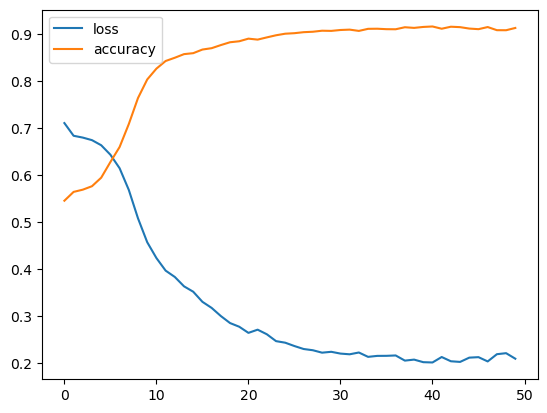

In [223]:
pd.DataFrame(history.history).plot()

### Phase de test
Une fois la phase d'entraînement terminé on va vérifier ce que vaut notre modèle avec des nouvelles données

In [224]:
y_predictions=(model.predict(x_test) > 0.5).astype(int) 

810/810 [==============================] - 1s 999us/step


### Évaluation de notre modèle à travers différentes métriques
Il existe plusieurs métriques pour évaluer un modèle. Ici je choisis d'utiliser la matrice de confusion et l'accuracy
1er métrique : Matrice de confusion 

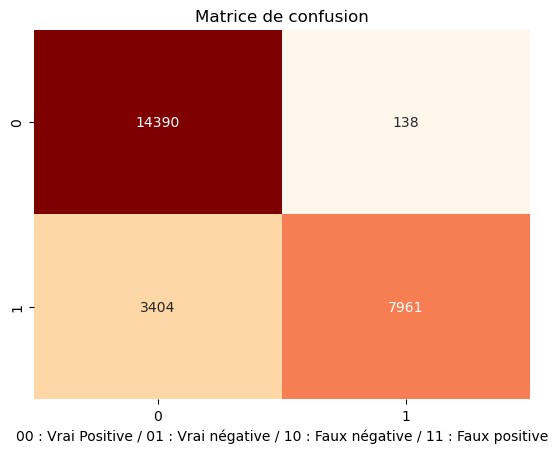

In [225]:
sns.heatmap(confusion_matrix(y_test, y_predictions), annot=True, fmt='g', cbar=False, cmap='OrRd')
plt.title("Matrice de confusion")
plt.xlabel('00 : Vrai Positive / 01 : Vrai négative / 10 : Faux négative / 11 : Faux positive')
plt.show()

2e métrique : Accuracy

In [226]:
print('Accuracy Score: ', '{:.2f}%'.format(accuracy_score(y_test, y_predictions)*100))

Accuracy Score:  86.32%
